In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv(
    "../cases_f.csv",
    encoding="utf-8",
    encoding_errors="ignore",
    engine="c",
    on_bad_lines="warn",
)
df.head(3)

,short_description,description,service_offering,business_service,resolved_at,u_case_type,u_organization
0,LogPoint Call - UCSD,received from: mike@lh.logpointus.com\n\nHi Ro...,Office 365,Collaboration Services,2023-02-06 23:22:49,Request,IT Services
1,Part 2 Scholarships or Grants,My 1098-T form currently states an amount for ...,1098T Other,Form 1098T,2023-02-11 14:40:52,Request,Student Support
2,"Delegate in eRA Commons, please","received from: aminvielle@ucsd.edu\n\nHello,\n...",Research Administration Support,Research Support Services,2023-02-10 16:42:07,Request,Research


# Exploratory Data Analysis

In [3]:
ticket_dist = (
    df
    .groupby("u_organization", dropna=False)
    .size()
    .sort_values()
) / df.shape[0]

<AxesSubplot: title={'center': 'Distribution of tickets among different organizations'}, ylabel='u_organization'>

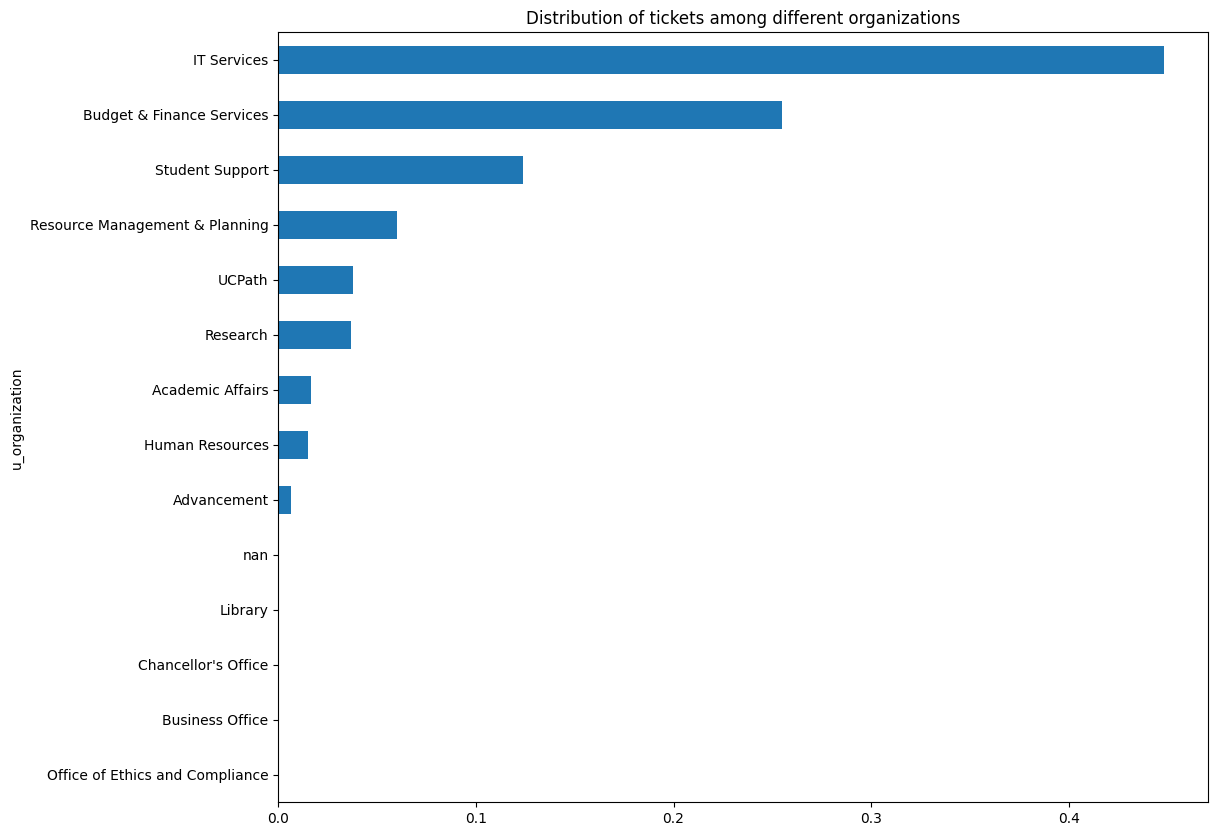

In [4]:
# Find the distribution of tickets among different organizations under ServiceNow
ticket_dist.plot(
    kind="barh",
    figsize=(12, 10),
    title="Distribution of tickets among different organizations"
)

In [5]:
ticket_dist.values[-1:-5:-1].sum()

0.8871320000000001

#### Omitting the null class, we have 13 possible classes. Of which, 6 classes appeared with less than 2% of the time. and 4 classes are below 5%. This means that we may get high accuracy for classifying tickets that may fall into the 4 categories that comprises 88.7% of the training data.

We may want to separate the data into two groups: one for the top 4 organizations and the other for the rest.
Alternatively, we can use a third group with all of the organizations to test our accuracy

In [6]:
df.columns

Index(['short_description', 'description', 'service_offering',
       'business_service', 'resolved_at', 'u_case_type', 'u_organization'],
      dtype='object')

In [7]:
service_dist = (
    df
    .groupby("service_offering", dropna=False)
    .size()
    .sort_values()
) / df.shape[0]

The range of the distribution is about 8.59% which means that they are pretty evenly distributed and we don't have to worry about an class inbalance problem

In [8]:
service_dist.describe()

count    895.000000
mean       0.001117
std        0.004975
min        0.000001
25%        0.000017
50%        0.000097
75%        0.000492
max        0.085926
dtype: float64

[0, 0.001205]


<AxesSubplot: >

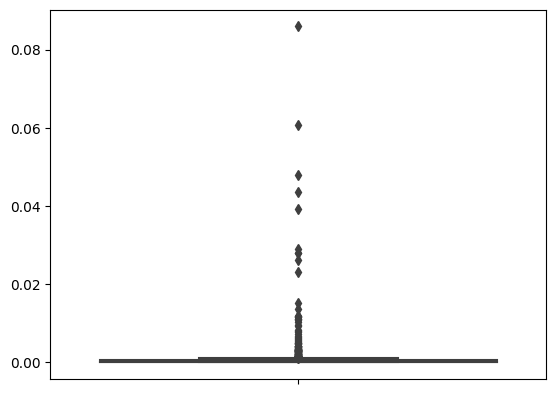

In [9]:
c = 1.5
q3 = service_dist.quantile(0.75)
q1 = service_dist.quantile(0.25)
IQR = q3 - q1
val_range = [max(0, q1 - c * IQR),  max(0, q3 + c * IQR)]
print(val_range)
sns.boxplot(y = service_dist.values)

# Models

# Problem
Sevice offering are often specific to the organization. If our prediction for service offering does not match the organization it falls under, how should we treat it?
Approach
1) We can group by each organization and have the user select the organization so we can narrow the problem down the prediction output to be R1 instead of R2
2) We enforce a constraints so that if the algorithm predicts a serivce offering, then it must predict a organization that it falls under
3) We only predict service offering and we select the organization based on it.

We are going with approach number 3

Data Wrangling:

In [ ]:
df_all = df.assign(
    desc_len = df.description.str.len(),
    num_tokens = df.description.str.split().str.len(),
)

Fill in the missing values with blank strings for text data and 0 for numerical data.

In [ ]:
df = df.dropna(subset=["service_offering"])
df.short_description = df.short_description.fillna("")
df.description = df.description.fillna("")
df.business_service = df.business_service.fillna("")
df.desc_len = df.desc_len.fillna(0)
df.num_tokens = df.num_tokens.fillna(0)

Exploratory Data Analysis

In [ ]:
df.describe()

In [ ]:
service_off_graph1 = df.groupby("service_offering").agg({
    "description": "count",
    "desc_len": ["mean", "median"],
    "num_tokens": ["mean", "median"],
}).sort_values(("description", "count"), ascending=False)

In [ ]:
(
    df["service_offering"]
    .value_counts(normalize=True)[10::-1]
    .plot(kind="barh")
)

In [ ]:
(
    df["business_service"]
    .value_counts(normalize=True)[10::-1]
    .plot(kind="barh")
)

We want to find the distribution of the character length of the description and number of tokens so we can find their distribution.

In [ ]:
sns.histplot(df["desc_len"], bins=10)

In [ ]:
sns.histplot(df["num_tokens"], bins=10)

Since the distribution is heavily skewed to the right, we are opting to use a logarithmic scale since it deals great with outlier. If we opted to use the Z-score, the mean would be heavily skewed to the right and mean would be significantly greater than the median.

In [ ]:
df = df.assign(
    log_desc_len = np.log(df.desc_len),
    log_num_tokens = np.log(df.num_tokens),
)

No newton-cholesky because it has a quadratic dependence on the number of features.

In [ ]:
X1, X2, y = df.log_desc_len, df.log_num_tokens, df.service_offering